Dataset from https://www.kaggle.com/paultimothymooney/kermany2018

In [1]:
from keras.applications import MobileNet
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Loading the MobileNet Model

In [2]:
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
mobile = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in mobile.layers:
    layer.trainable = False
    
for (i,layer) in enumerate(mobile.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 ReLU False
11 ZeroPadding2D False
12 DepthwiseConv2D False
13 BatchNormalization False
14 ReLU False
15 Conv2D False
16 BatchNormalization False
17 ReLU False
18 DepthwiseConv2D False
19 BatchNormalization False
20 ReLU False
21 Conv2D False
22 BatchNormalization False
23 ReLU False
24 ZeroPadding2D False
25 DepthwiseConv2D False
26 BatchNormalization False
27 ReLU False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 ReLU False
37 ZeroPadding2D False
38 DepthwiseConv2D False
39 BatchNormalization False
40 ReLU False
41 Conv2D False
42 BatchNormalization False
43 ReLU False
44 DepthwiseConv2D False
45 BatchNormalization False
46 ReLU False
47 Conv2D False
48 Batc

### Let's make a function that returns our FC Head

In [3]:
def addTopModel(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model=GlobalAveragePooling2D()(top_model)
    top_model=Dense(1024,activation='relu')(top_model) 
    top_model=Dense(1024,activation='relu')(top_model) 
    top_model=Dense(512,activation='relu')(top_model) 
    top_model = Dense(num_classes, activation = "softmax")(top_model)

    return top_model

### Let's add our FC Head back onto MobileNet

In [4]:
num_classes = 4

FC_Head = addTopModel(mobile, num_classes)

model = Model(inputs=mobile.input, outputs=FC_Head)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

### Loading Retinal Dataset

In [5]:
train_data_dir = 'OCT2017/train'
validation_data_dir = 'OCT2017/test'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
batch_size=16
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 34464 images belonging to 4 classes.
Found 3223 images belonging to 4 classes.


### Training our top layers

In [7]:
checkpoint = ModelCheckpoint("retinal_mobile1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint]

In [8]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy'])

In [9]:
nb_train_samples = 34464
nb_validation_samples = 3223

epochs = 10
batch_size = 16

In [10]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
2154/2154 [==============================] - 970s 450ms/step - loss: 0.6709 - acc: 0.7387 - val_loss: 1.2150 - val_acc: 0.5955

Epoch 00001: val_loss improved from inf to 1.21496, saving model to retinal_mobile1.h5
Epoch 2/10
2154/2154 [==============================] - 483s 224ms/step - loss: 0.5711 - acc: 0.7794 - val_loss: 1.2573 - val_acc: 0.5847

Epoch 00002: val_loss did not improve from 1.21496
Epoch 3/10
2154/2154 [==============================] - 539s 250ms/step - loss: 0.5385 - acc: 0.7937 - val_loss: 1.0514 - val_acc: 0.6330

Epoch 00003: val_loss improved from 1.21496 to 1.05144, saving model to retinal_mobile1.h5
Epoch 4/10
2154/2154 [==============================] - 488s 226ms/step - loss: 0.5151 - acc: 0.8017 - val_loss: 0.8748 - val_acc: 0.7191

Epoch 00004: val_loss improved from 1.05144 to 0.87478, saving model to retinal_mobile1.h5
Epoch 5/10
2154/2154 [==============================] - 493s 229ms/step - loss: 0.5104 - acc: 0.8068 - val_loss: 0.7096 - va

In [11]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

202/202 [==============================] - 36s 178ms/step

Test result: 71.269 loss: 0.717


In [12]:
model.save("retinal_mobile.h5")

## Confusion Matrix

In [13]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 3223 images belonging to 4 classes.


In [14]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

In [15]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)

In [16]:
y_pred_label = np.argmax(y_pred, axis=1)

In [17]:
validation_generator.classes.shape,y_pred_label.shape

((3223,), (3223,))

In [18]:
#Confusion Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred_label))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Confusion Matrix
[[102  17 118   5]
 [  4 433  96 466]
 [  0   3 780 200]
 [  0   3  16 980]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.96      0.42      0.59       242
         DME       0.95      0.43      0.60       999
      DRUSEN       0.77      0.79      0.78       983
      NORMAL       0.59      0.98      0.74       999

   micro avg       0.71      0.71      0.71      3223
   macro avg       0.82      0.66      0.68      3223
weighted avg       0.79      0.71      0.70      3223



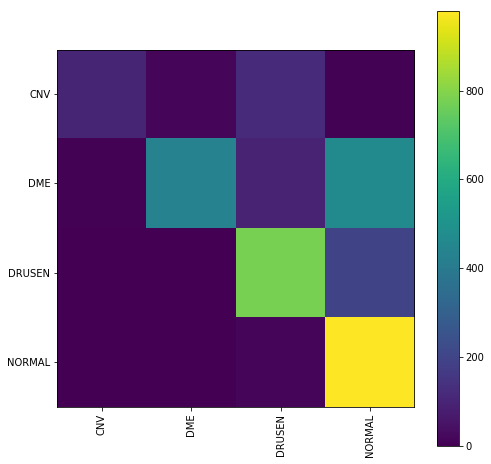

In [19]:
plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
plt.show();

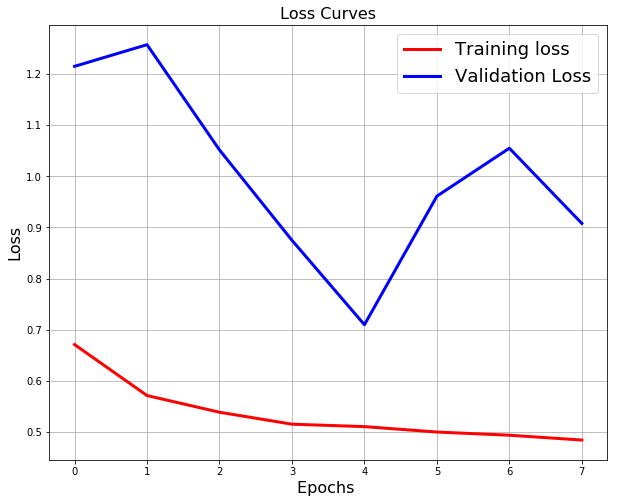

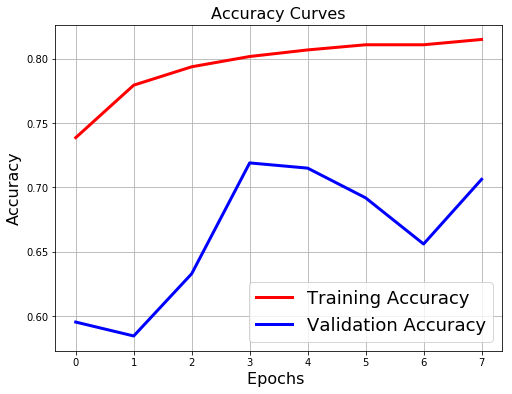

In [20]:
# Loss Curves
plt.figure(figsize=[10,8])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.grid()
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16);

### Loading our classifer


In [1]:
from keras.applications import MobileNet
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt

classifier = load_model("retinal_mobile.h5")

Using TensorFlow backend.


### Testing on some images

In [2]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join

In [3]:
retinal_dict = {"[0]": "CNV", 
                      "[1]": "DME",
                      "[2]": "DRUSEN",
                      "[3]": "NORMAL"}

retinal_dict_n = {"CNV": "CNV ", 
                      "DME": "DME",
                      "DRUSEN": "DRUSEN",
                      "NORMAL": "NORMAL"}

In [4]:
def draw_test(name, pred, im):
    retinal = retinal_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, retinal, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.imshow(name, expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + retinal_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,10):
    input_im = getRandomImage("OCT2017/val/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()

Class - NORMAL
Class - DME
Class - CNV 
Class - DME
Class - DME
Class - DRUSEN
Class - DME
Class - DME
Class - DRUSEN
Class - CNV 


<img src="Retinal-MobileNet.png">

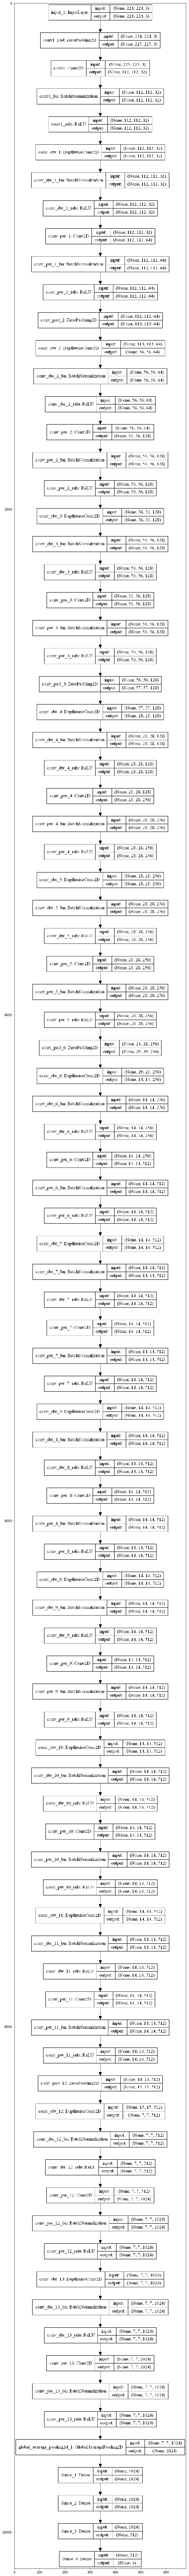

In [9]:
from keras.utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Generate the plot
plot_model(classifier, to_file ='model_plot_retinal_mobile.png',
           show_shapes = True,
           show_layer_names = True)

# Show the plot here
img = mpimg.imread('model_plot_retinal_mobile.png')
plt.figure(figsize=(120,150))
imgplot = plt.imshow(img)